# Model Preparation and XGBoost

The main purpose of this notebook is to prepare the dataset for modeling (train-test splitting, undersampling, and oversampling) and to create an XGBoost model.

# Imports

In [122]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import joblib

from google.colab import drive
drive.mount('/content/drive')
drive_dir = '/content/drive/My Drive/Project_3/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading the Data

In [2]:
df = pd.read_csv(drive_dir + 'data/promotion_train_data.csv')

In [3]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


# Exploring the Data

In this section, we will discover some basic statistics of our columns.

In [4]:
df.shape

(54808, 14)

In [5]:
df.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')

In [6]:
df.dtypes

employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object

In [7]:
df['department'].value_counts()

Sales & Marketing    16840
Operations           11348
Technology            7138
Procurement           7138
Analytics             5352
Finance               2536
HR                    2418
Legal                 1039
R&D                    999
Name: department, dtype: int64

In [8]:
df['region'].value_counts()

region_2     12343
region_22     6428
region_7      4843
region_15     2808
region_13     2648
region_26     2260
region_31     1935
region_4      1703
region_27     1659
region_16     1465
region_28     1318
region_11     1315
region_23     1175
region_29      994
region_32      945
region_19      874
region_20      850
region_14      827
region_25      819
region_17      796
region_5       766
region_6       690
region_30      657
region_8       655
region_10      648
region_1       610
region_24      508
region_12      500
region_9       420
region_21      411
region_3       346
region_34      292
region_33      269
region_18       31
Name: region, dtype: int64

In [9]:
df['education'].value_counts()

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

In [10]:
df['gender'].value_counts()

m    38496
f    16312
Name: gender, dtype: int64

In [11]:
df['recruitment_channel'].value_counts()

other       30446
sourcing    23220
referred     1142
Name: recruitment_channel, dtype: int64

In [12]:
df['no_of_trainings'].describe()

count    54808.000000
mean         1.253011
std          0.609264
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         10.000000
Name: no_of_trainings, dtype: float64

In [13]:
df['no_of_trainings'].value_counts()

1     44378
2      7987
3      1776
4       468
5       128
6        44
7        12
10        5
9         5
8         5
Name: no_of_trainings, dtype: int64

In [14]:
df['age'].describe()

count    54808.000000
mean        34.803915
std          7.660169
min         20.000000
25%         29.000000
50%         33.000000
75%         39.000000
max         60.000000
Name: age, dtype: float64

In [16]:
df['previous_year_rating'].value_counts()

3.0    18618
5.0    11741
4.0     9877
1.0     6223
2.0     4225
Name: previous_year_rating, dtype: int64

In [18]:
df['length_of_service'].describe()

count    54808.000000
mean         5.865512
std          4.265094
min          1.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         37.000000
Name: length_of_service, dtype: float64

In [19]:
df['KPIs_met >80%'].value_counts()

0    35517
1    19291
Name: KPIs_met >80%, dtype: int64

In [20]:
df['awards_won?'].value_counts()

0    53538
1     1270
Name: awards_won?, dtype: int64

In [22]:
df['avg_training_score'].describe()

count    54808.000000
mean        63.386750
std         13.371559
min         39.000000
25%         51.000000
50%         60.000000
75%         76.000000
max         99.000000
Name: avg_training_score, dtype: float64

In [24]:
df['is_promoted'].value_counts(normalize=True)

0    0.91483
1    0.08517
Name: is_promoted, dtype: float64

#Cleaning Data

In this section, we will clean the data and look for missing values.

In [25]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


We will drop `employee_id` because this provides no insights.

In [26]:
df = df.drop('employee_id',axis = 1)

Looking for missing values.

In [28]:
for col in df.columns:
  percent = 100 * df[col].isna().sum() / df.shape[0]
  percent = round(percent,2)
  print(f'{col}: {df[col].isna().sum()} ({percent}%) missing values')

department: 0 (0.0%) missing values
region: 0 (0.0%) missing values
education: 2409 (4.4%) missing values
gender: 0 (0.0%) missing values
recruitment_channel: 0 (0.0%) missing values
no_of_trainings: 0 (0.0%) missing values
age: 0 (0.0%) missing values
previous_year_rating: 4124 (7.52%) missing values
length_of_service: 0 (0.0%) missing values
KPIs_met >80%: 0 (0.0%) missing values
awards_won?: 0 (0.0%) missing values
avg_training_score: 0 (0.0%) missing values
is_promoted: 0 (0.0%) missing values


In [29]:
df['education'].unique()

array(["Master's & above", "Bachelor's", nan, 'Below Secondary'],
      dtype=object)

In [30]:
#Replacing NaN instead of dropping b/c we want to keep those rows
df['education'] = df.education.fillna('Unknown')

In [31]:
df['previous_year_rating'].unique()

array([ 5.,  3.,  1.,  4., nan,  2.])

In [32]:
#Ratings are 1-5, so 0 will mean employee was not here last year
df['previous_year_rating'] = df.previous_year_rating.fillna(0)

In [35]:
df.dtypes

department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object

In [36]:
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


# Creating New Columns

In this section we will create new columns because they may prove to be useful later when creating models.

In [37]:
df['starting_age'] = df['age']-df['length_of_service']
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,starting_age
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,27
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,26
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,27
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,29
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,43


In [38]:
df['total_training_score'] = df['no_of_trainings']*df['avg_training_score']
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted,starting_age,total_training_score
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,27,49
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,26,60
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,27,50
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,29,100
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,43,73


In [39]:
df = df.rename(columns={'KPIs_met >80%': 'KPIs_met>80%'})

In [40]:
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,is_promoted,starting_age,total_training_score
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,27,49
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,26,60
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,27,50
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,29,100
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,43,73


In [41]:
df['previous_year_rating_norm'] = (df['previous_year_rating']-df['previous_year_rating'].min())/(df['previous_year_rating'].max()-df['previous_year_rating'].min())
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,is_promoted,starting_age,total_training_score,previous_year_rating_norm
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,27,49,1.0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,26,60,1.0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,27,50,0.6
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,29,100,0.2
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,43,73,0.6


In [42]:
#based off of percentages of promotion. Lowered older than 40 with 0 rating bc only 11 people
def age_rating(row):
  if row['age'] <= 40 and row['previous_year_rating'] == 0:
    return 10
  elif row['age'] <= 40 and row['previous_year_rating'] == 1:
    return 2
  elif row['age'] <= 40 and row['previous_year_rating'] == 2:
    return 4
  elif row['age'] <= 40 and row['previous_year_rating'] == 3:
    return 7
  elif row['age'] <= 40 and row['previous_year_rating'] == 4:
    return 9
  elif row['age'] <= 40 and row['previous_year_rating'] == 5:
    return 12
  elif row['age'] > 40 and row['previous_year_rating'] == 0:
    return 6
  elif row['age'] > 40 and row['previous_year_rating'] == 1:
    return 1
  elif row['age'] > 40 and row['previous_year_rating'] == 2:
    return 3
  elif row['age'] > 40 and row['previous_year_rating'] == 3:
    return 5
  elif row['age'] > 40 and row['previous_year_rating'] == 4:
    return 8
  else:
    return 11


In [43]:
def age_KPI(row):
  if row['age'] <= 45 and row['KPIs_met>80%'] == 0:
    return 2
  elif row['age'] <= 45 and row['KPIs_met>80%'] == 1:
    return 4
  elif row['age'] > 45 and row['KPIs_met>80%'] == 0:
    return 3
  else:
    return 1

In [44]:
df['age_rating'] = df.apply(age_rating, axis=1)

In [45]:
df['age_KPI'] = df.apply(age_KPI, axis=1)

#Looking for general facts

In [46]:
#Rating 0 means they were not there last year
#What do these 8% of people do to get promoted?
for i in df['previous_year_rating'].unique():
  rating_df = df[df['previous_year_rating'] == i]
  total = rating_df.shape[0]
  promoted = rating_df[rating_df['is_promoted'] == 1].shape[0]
  percent = 100*promoted/total
  print(f"Employee's with previous year rating {i} were promoted {percent: .2f}% of the time. ({promoted} out of {total})")

Employee's with previous year rating 5.0 were promoted  16.36% of the time. (1921 out of 11741)
Employee's with previous year rating 3.0 were promoted  7.28% of the time. (1355 out of 18618)
Employee's with previous year rating 1.0 were promoted  1.41% of the time. (88 out of 6223)
Employee's with previous year rating 4.0 were promoted  7.94% of the time. (784 out of 9877)
Employee's with previous year rating 0.0 were promoted  8.22% of the time. (339 out of 4124)
Employee's with previous year rating 2.0 were promoted  4.28% of the time. (181 out of 4225)


In [48]:
zero_df = df[df['previous_year_rating'] == 0]

In [49]:
#Looks like average training score is an important factor for promotions
#0 is not promoted
#1 is promoted
for i, group in zero_df.groupby('is_promoted'):
  training_score_mean = group['avg_training_score'].mean()
  print(f"The average training score for {i} with a 0 previous year rating was {training_score_mean}")

for i, group in df.groupby('is_promoted'):
  training_score_mean = group['avg_training_score'].mean()
  print(f"The average training score for all people for {i} rating was {training_score_mean}")


The average training score for 0 with a 0 previous year rating was 62.589696169088505
The average training score for 1 with a 0 previous year rating was 71.929203539823
The average training score for all people for 0 rating was 62.64768647786199
The average training score for all people for 1 rating was 71.32519280205655


In [50]:
#This seems hand picked
for department,group in df.groupby('department'):
  total = group.shape[0]
  promoted = group[group['is_promoted'] == 1].shape[0]
  percent = 100*promoted/total
  print(f"Employees in the {department} department were promoted {percent:.2f}% of the time. ({promoted} out of {total})")

Employees in the Analytics department were promoted 9.57% of the time. (512 out of 5352)
Employees in the Finance department were promoted 8.12% of the time. (206 out of 2536)
Employees in the HR department were promoted 5.62% of the time. (136 out of 2418)
Employees in the Legal department were promoted 5.10% of the time. (53 out of 1039)
Employees in the Operations department were promoted 9.01% of the time. (1023 out of 11348)
Employees in the Procurement department were promoted 9.64% of the time. (688 out of 7138)
Employees in the R&D department were promoted 6.91% of the time. (69 out of 999)
Employees in the Sales & Marketing department were promoted 7.20% of the time. (1213 out of 16840)
Employees in the Technology department were promoted 10.76% of the time. (768 out of 7138)


In [51]:
#These are not as similar which is good
#Seems like females are being promoted more than males
for department,group in df.groupby('department'):
  male_df = group[group['gender'] == 'm']
  female_df = group[group['gender'] == 'f']
  total_male = male_df.shape[0]
  total_female = female_df.shape[0]
  promoted_male = male_df[male_df['is_promoted'] == 1].shape[0]
  promoted_female = female_df[female_df['is_promoted'] == 1].shape[0]
  percent_male = 100*promoted_male/total_male
  percent_female = 100*promoted_female/total_female
  print(f"Males in the {department} department were promoted {percent_male:.2f}% of the time. ({promoted_male} out of {total_male})")
  print(f"Females in the {department} department were promoted {percent_female:.2f}% of the time. ({promoted_female} out of {total_female})")
  print('='*100)

Males in the Analytics department were promoted 9.30% of the time. (450 out of 4839)
Females in the Analytics department were promoted 12.09% of the time. (62 out of 513)
Males in the Finance department were promoted 8.14% of the time. (151 out of 1855)
Females in the Finance department were promoted 8.08% of the time. (55 out of 681)
Males in the HR department were promoted 5.52% of the time. (78 out of 1412)
Females in the HR department were promoted 5.77% of the time. (58 out of 1006)
Males in the Legal department were promoted 5.28% of the time. (47 out of 890)
Females in the Legal department were promoted 4.03% of the time. (6 out of 149)
Males in the Operations department were promoted 8.71% of the time. (581 out of 6671)
Females in the Operations department were promoted 9.45% of the time. (442 out of 4677)
Males in the Procurement department were promoted 7.87% of the time. (303 out of 3851)
Females in the Procurement department were promoted 11.71% of the time. (385 out of 328

# Model Building Preparation

# Label Encoding

We will encode our data so it can be used by our models.

In [52]:
df_encoded = df.copy()

In [54]:
for c in df_encoded.columns:
  if c != 'default':  
    if df_encoded[c].dtype == object:  #If it is a string, then encode it. 
        try:  
            le = LabelEncoder()           
            le.fit(df_encoded[c].unique())    
            df_encoded[c] = le.transform(df_encoded[c])  
        except Exception as e:         
            print(c)         
            print(e)

In [55]:
df_encoded.dtypes

department                     int64
region                         int64
education                      int64
gender                         int64
recruitment_channel            int64
no_of_trainings                int64
age                            int64
previous_year_rating         float64
length_of_service              int64
KPIs_met>80%                   int64
awards_won?                    int64
avg_training_score             int64
is_promoted                    int64
starting_age                   int64
total_training_score           int64
previous_year_rating_norm    float64
age_rating                     int64
age_KPI                        int64
dtype: object

In [56]:
df_encoded['gender'].value_counts()

1    38496
0    16312
Name: gender, dtype: int64

In [57]:
df['gender'].value_counts()

m    38496
f    16312
Name: gender, dtype: int64

In [58]:
df.columns

Index(['department', 'region', 'education', 'gender', 'recruitment_channel',
       'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'KPIs_met>80%', 'awards_won?', 'avg_training_score', 'is_promoted',
       'starting_age', 'total_training_score', 'previous_year_rating_norm',
       'age_rating', 'age_KPI'],
      dtype='object')

We want to create separate subsets of data for males and females to build our models to see if they differ at all.

In [62]:
female_df = df_encoded[df_encoded['gender']==0]
male_df = df_encoded[df_encoded['gender']==1]

female_train_df, female_test_df = train_test_split(female_df, test_size=0.3, random_state=0, stratify=female_df['is_promoted'])
male_train_df, male_test_df = train_test_split(male_df, test_size=0.3, random_state=0, stratify=male_df['is_promoted'])

In [63]:
feat_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 
             'previous_year_rating', 'length_of_service', 'KPIs_met>80%', 'awards_won?', 'avg_training_score', 
             'starting_age', 'total_training_score', 'previous_year_rating_norm', 'age_rating', 'age_KPI']
target_col = 'is_promoted'

female_X_train = female_train_df[feat_cols]
female_y_train = female_train_df[target_col]

male_X_train = male_train_df[feat_cols]
male_y_train = male_train_df[target_col]

female_X_test = female_test_df[feat_cols]
female_y_test = female_test_df[target_col]

male_X_test = male_test_df[feat_cols]
male_y_test = male_test_df[target_col]

In [64]:
female_X_train.to_csv(drive_dir + 'data/female_X_train.csv')

In [65]:
female_y_train.to_csv(drive_dir + 'data/female_y_train.csv')

In [66]:
male_X_train.to_csv(drive_dir + 'data/male_X_train.csv')

In [67]:
male_y_train.to_csv(drive_dir + 'data/male_y_train.csv')

In [68]:
female_X_test.to_csv(drive_dir + 'data/female_X_test.csv')

In [69]:
female_y_test.to_csv(drive_dir + 'data/female_y_test.csv')

In [70]:
male_X_test.to_csv(drive_dir + 'data/male_X_test.csv')

In [71]:
male_y_test.to_csv(drive_dir + 'data/male_y_test.csv')

# Undersampling

We will undersample our data first.

In [73]:
female_train_df['is_promoted'].value_counts()

0    10391
1     1027
Name: is_promoted, dtype: int64

In [74]:
male_train_df['is_promoted'].value_counts()

0    24706
1     2241
Name: is_promoted, dtype: int64

In [75]:
# Get only the customers who did not get promoted
female_train_no_df = female_train_df[female_train_df['is_promoted'] == 0]
# Then select of them to match the "1" is_promoted employees
female_train_no_df = female_train_no_df.sample(1027)

# Also grab the promoted employees
female_train_yes_df = female_train_df[female_train_df['is_promoted'] == 1]

# And now stick both DataFrames together to make a new undersampled training set
female_train_under_df = pd.concat([female_train_no_df, female_train_yes_df])

In [76]:
# Get only the customers who did not get promoted
male_train_no_df = male_train_df[male_train_df['is_promoted'] == 0]
# Then select of them to match the "1" is_promoted employees
male_train_no_df = male_train_no_df.sample(2241)

# Also grab the promoted employees
male_train_yes_df = male_train_df[male_train_df['is_promoted'] == 1]

# And now stick both DataFrames together to make a new undersampled training set
male_train_under_df = pd.concat([male_train_no_df, male_train_yes_df])

In [77]:
female_train_under_df['is_promoted'].value_counts()

1    1027
0    1027
Name: is_promoted, dtype: int64

In [78]:
male_train_under_df['is_promoted'].value_counts()

1    2241
0    2241
Name: is_promoted, dtype: int64

In [79]:
feat_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 
             'previous_year_rating', 'length_of_service', 'KPIs_met>80%', 'awards_won?', 'avg_training_score', 
             'starting_age', 'total_training_score', 'previous_year_rating_norm', 'age_rating', 'age_KPI']
target_col = 'is_promoted'

female_X_train_under = female_train_under_df[feat_cols]
female_y_train_under = female_train_under_df[target_col]

In [80]:
male_X_train_under = male_train_under_df[feat_cols]
male_y_train_under = male_train_under_df[target_col]

In [81]:
female_X_train_under.to_csv(drive_dir + 'data/female_X_train_under.csv')

In [82]:
female_y_train_under.to_csv(drive_dir + 'data/female_y_train_under.csv')

In [83]:
male_X_train_under.to_csv(drive_dir + 'data/male_X_train_under.csv')

In [84]:
male_y_train_under.to_csv(drive_dir + 'data/male_y_train_under.csv')

# Oversampling

We will now oversample our data. Later we will build models on both undersampled and oversampled data and see which one fares the best.

In [86]:
female_train_df['is_promoted'].value_counts()

0    10391
1     1027
Name: is_promoted, dtype: int64

In [87]:
male_train_df['is_promoted'].value_counts()

0    24706
1     2241
Name: is_promoted, dtype: int64

In [88]:
female_train_yes_df = female_train_df[female_train_df['is_promoted'] == 1]
female_train_yes_df = female_train_yes_df.sample(10391, replace=True)

female_train_no_df = female_train_df[female_train_df['is_promoted'] == 0]

# And now stick both DataFrames together to make a new oversampled training set
female_train_over_df = pd.concat([female_train_no_df, female_train_yes_df])

In [89]:
male_train_yes_df = male_train_df[male_train_df['is_promoted'] == 1]
male_train_yes_df = male_train_yes_df.sample(24706, replace=True)

male_train_no_df = male_train_df[male_train_df['is_promoted'] == 0]

# And now stick both DataFrames together to make a new oversampled training set
male_train_over_df = pd.concat([male_train_no_df, male_train_yes_df])

In [92]:
female_train_over_df['is_promoted'].value_counts()

1    10391
0    10391
Name: is_promoted, dtype: int64

In [93]:
male_train_over_df['is_promoted'].value_counts()

1    24706
0    24706
Name: is_promoted, dtype: int64

In [94]:
feat_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 
             'previous_year_rating', 'length_of_service', 'KPIs_met>80%', 'awards_won?', 'avg_training_score', 
             'starting_age', 'total_training_score', 'previous_year_rating_norm', 'age_rating', 'age_KPI']
target_col = 'is_promoted'

female_X_train_over = female_train_over_df[feat_cols]
female_y_train_over = female_train_over_df[target_col]

In [95]:
male_X_train_over = male_train_over_df[feat_cols]
male_y_train_over = male_train_over_df[target_col]

In [96]:
female_X_train_over.to_csv(drive_dir + 'data/female_X_train_over.csv')

In [97]:
female_y_train_over.to_csv(drive_dir + 'data/female_y_train_over.csv')

In [98]:
male_X_train_over.to_csv(drive_dir + 'data/male_X_train_over.csv')

In [99]:
male_y_train_over.to_csv(drive_dir + 'data/male_y_train_over.csv')

# XGBoost

We will now create an XGBoost model to predict males and females who were promoted and not promoted.

# GridsearchCV

In [ ]:
xgb_clf = XGBClassifier(tree_method='gpu_hist')
hyperparams = {'n_estimators': [100, 150, 200],
               'max_depth': [50, 100, 150, 200, 250],
               'learning_rate': [1e-4, 1e-3, 1e-2, 0.1, 1]}

grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=hyperparams)

grid_search.fit(male_X_train_over, male_y_train_over)

In [ ]:
grid_search.best_params_

In [ ]:
best_model = grid_search.best_estimator_

In [ ]:
best_model

In [ ]:
xgb_clf = XGBClassifier(tree_method='gpu_hist')
hyperparams = {'n_estimators': [100, 150, 200],
               'max_depth': [50, 100, 150, 200, 250],
               'learning_rate': [1e-4, 1e-3, 1e-2, 0.1, 1]}

grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=hyperparams)

grid_search.fit(male_X_train_under, male_y_train_under)

In [ ]:
grid_search.best_params_

In [ ]:
xgb_clf = XGBClassifier()
hyperparams = {'n_estimators': [5, 10, 25, 50, 100],
               'max_depth': [5, 10, 25, 50, 100, 150],
               'learning_rate': [1e-4, 1e-3, 1e-2, 0.1, 1]}

grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=hyperparams)

grid_search.fit(female_X_train_over, female_y_train_over)

In [ ]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 50, 'n_estimators': 100}

In [ ]:
xgb_clf = XGBClassifier()
hyperparams = {'n_estimators': [5, 10, 25, 50, 100],
               'max_depth': [5, 10, 25, 50, 100, 150],
               'learning_rate': [1e-4, 1e-3, 1e-2, 0.1, 1]}

grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=hyperparams)

grid_search.fit(female_X_train_under, female_y_train_under)

In [ ]:
grid_search.best_params_

# Male (Undersampled)

In [101]:
xgb_clf_male_under = XGBClassifier(learning_rate=0.1, max_depth=50, n_estimators=100)
xgb_clf_male_under.fit(male_X_train_under, male_y_train_under)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

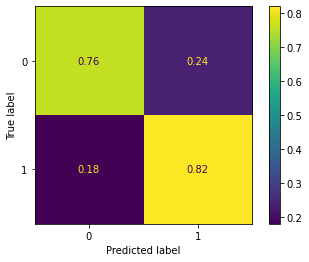

In [103]:
plot_confusion_matrix(xgb_clf_male_under, male_X_test, male_y_test, normalize='true')

In [105]:
male_under_pred = xgb_clf_male_under.predict(male_X_test)
print("Accuracy for male undersampled model: %.2f" % (accuracy_score(male_y_test, male_under_pred) * 100))

Accuracy for male undersampled model: 76.74


In [106]:
print(classification_report(male_y_test, male_under_pred))

              precision    recall  f1-score   support

           0       0.98      0.76      0.86     10589
           1       0.24      0.82      0.37       960

    accuracy                           0.77     11549
   macro avg       0.61      0.79      0.61     11549
weighted avg       0.92      0.77      0.82     11549



As we can see from the classification report, this specific model does a poor job of predicting males who were promoted.

Next we want to see what columns the model thought was important in making predicitons.

In [108]:
featuredf = pd.DataFrame(xgb_clf_male_under.feature_importances_, male_X_train_under.columns)

In [109]:
featuredf = featuredf.sort_values(by=0, ascending=False)
featuredf[0] = featuredf[0]*100
featuredf = featuredf[:10]

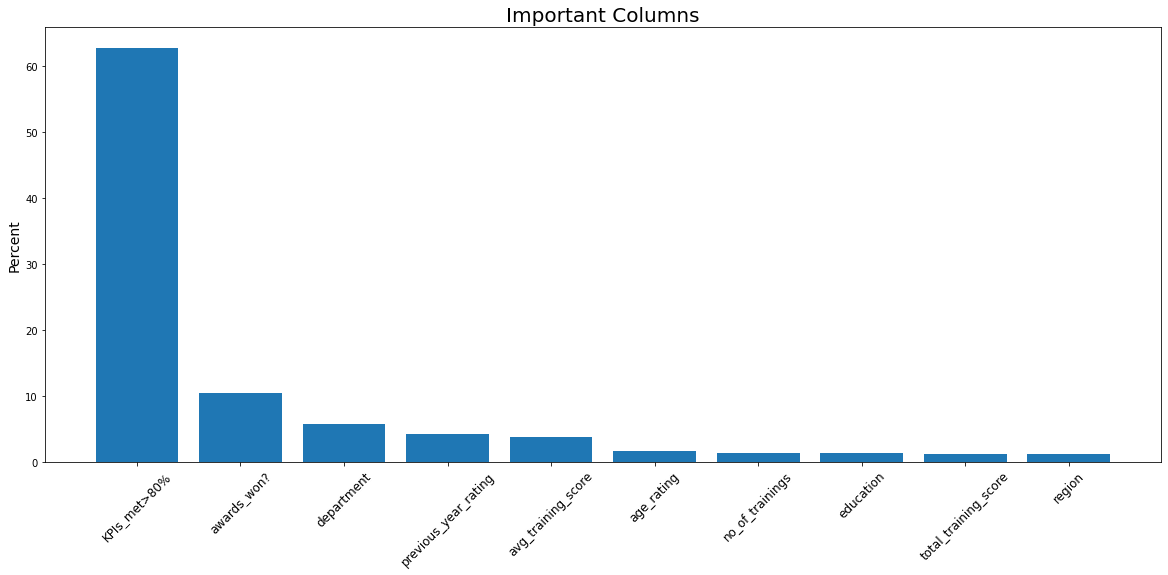

In [110]:
plt.figure(figsize=(20, 8))

x = featuredf.index
y = featuredf[0]

plt.title('Important Columns', fontsize =20)
plt.bar(x, y)
plt.xticks(rotation=45, fontsize = 12)
plt.ylabel('Percent', fontsize=14);

# Male (Oversampled)

Next we want to create an XGBoost model using the male oversampled data.

In [111]:
xgb_clf_male_over = XGBClassifier(learning_rate=0.1, max_depth=50, n_estimators=100)

In [112]:
xgb_clf_male_over.fit(male_X_train_over, male_y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

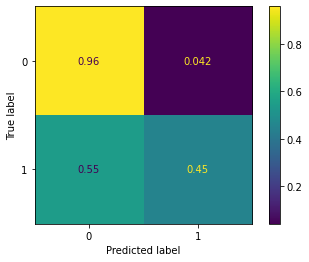

In [113]:
plot_confusion_matrix(xgb_clf_male_over, male_X_test, male_y_test, normalize='true')

In [114]:
male_over_pred = xgb_clf_male_over.predict(male_X_test)
print("Accuracy for male oversampled model: %.2f" % (accuracy_score(male_y_test, male_over_pred) * 100))

Accuracy for male oversampled model: 91.62


In [115]:
male_pred_df = pd.DataFrame(male_over_pred, columns=['predictions'])

In [116]:
male_pred_df.head()

,predictions
0,0
1,0
2,0
3,0
4,0


In [117]:
male_pred_df.to_csv(drive_dir + 'data/male_pred_xgb.csv')

In [118]:
print(classification_report(male_y_test, male_over_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     10589
           1       0.50      0.45      0.47       960

    accuracy                           0.92     11549
   macro avg       0.72      0.70      0.71     11549
weighted avg       0.91      0.92      0.91     11549



A slight improvement from the undersampled data as seen in the f1-scores, but still doing a poor job of predicting those who were promoted.

In [119]:
featuredf = pd.DataFrame(xgb_clf_male_over.feature_importances_, male_X_train_over.columns)

In [120]:
featuredf = featuredf.sort_values(by=0, ascending=False)
featuredf[0] = featuredf[0]*100
featuredf = featuredf[:10]

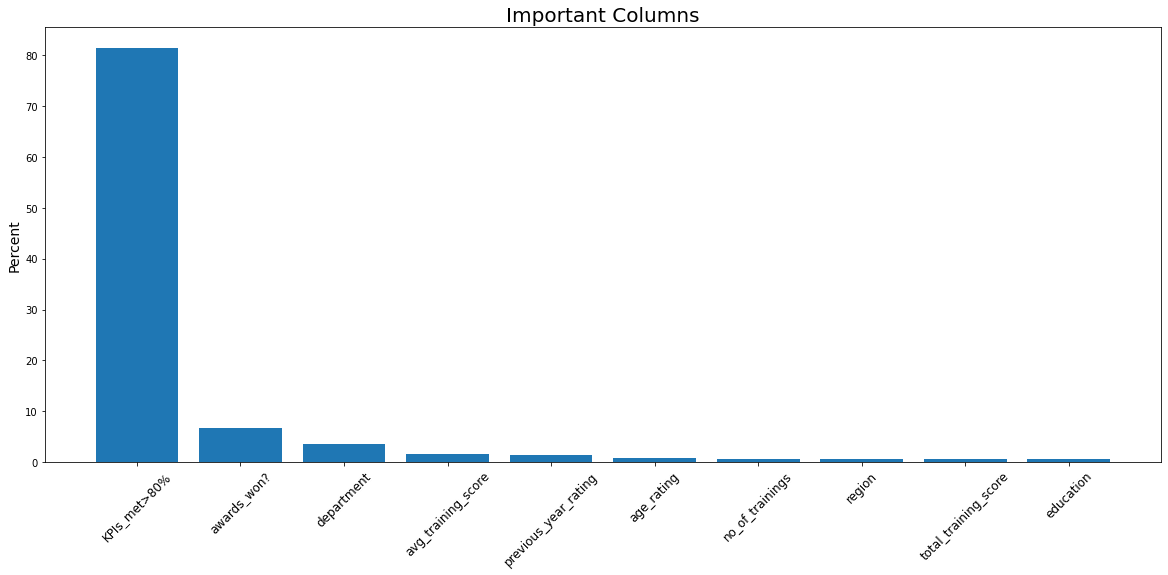

In [121]:
plt.figure(figsize=(20, 8))

x = featuredf.index
y = featuredf[0]

plt.title('Important Columns', fontsize =20)
plt.bar(x, y)
plt.xticks(rotation=45, fontsize = 12)
plt.ylabel('Percent', fontsize=14);

In [123]:
joblib.dump(xgb_clf_male_over, drive_dir + 'models/male_over_xgb.joblib')

['/content/drive/My Drive/Project_3/models/male_over_xgb.joblib']

To investigate our model more, we further split the male subset into those who have met 80% of their KPIs and those who have not met 80% of their KPIs. So we will repeat our process of oversampling the data and then creating two more XGBoost models.

In [124]:
male_KPI_df = male_df[male_df['KPIs_met>80%']==1]

In [125]:
male_noKPI_df = male_df[male_df['KPIs_met>80%']==0]

In [126]:
male_KPI_train_df, male_KPI_test_df = train_test_split(male_KPI_df, test_size=0.3, random_state=0, stratify=male_KPI_df['is_promoted'])
male_noKPI_train_df, male_noKPI_test_df = train_test_split(male_noKPI_df, test_size=0.3, random_state=0, stratify=male_noKPI_df['is_promoted'])

In [127]:
feat_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 
             'previous_year_rating', 'length_of_service', 'awards_won?', 'avg_training_score', 
             'starting_age', 'total_training_score', 'previous_year_rating_norm', 'age_rating']
target_col = 'is_promoted'

male_KPI_X_train = male_KPI_train_df[feat_cols]
male_KPI_y_train = male_KPI_train_df[target_col]

male_noKPI_X_train = male_noKPI_train_df[feat_cols]
male_noKPI_y_train = male_noKPI_train_df[target_col]

male_KPI_X_test = male_KPI_test_df[feat_cols]
male_KPI_y_test = male_KPI_test_df[target_col]

male_noKPI_X_test = male_noKPI_test_df[feat_cols]
male_noKPI_y_test = male_noKPI_test_df[target_col]

In [128]:
male_KPI_X_train.columns

Index(['department', 'region', 'education', 'gender', 'recruitment_channel',
       'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'awards_won?', 'avg_training_score', 'starting_age',
       'total_training_score', 'previous_year_rating_norm', 'age_rating'],
      dtype='object')

In [129]:
male_KPI_train_df['is_promoted'].value_counts()

0    7613
1    1558
Name: is_promoted, dtype: int64

In [130]:
male_noKPI_train_df['is_promoted'].value_counts()

0    17093
1      682
Name: is_promoted, dtype: int64

In [131]:
male_KPI_train_yes_df = male_KPI_train_df[male_KPI_train_df['is_promoted'] == 1]
male_KPI_train_yes_df = male_KPI_train_yes_df.sample(7613, replace=True)

male_KPI_train_no_df = male_KPI_train_df[male_KPI_train_df['is_promoted'] == 0]

# And now stick both DataFrames together to make a new oversampled training set
male_KPI_train_over_df = pd.concat([male_KPI_train_no_df, male_KPI_train_yes_df])

In [132]:
male_noKPI_train_yes_df = male_noKPI_train_df[male_noKPI_train_df['is_promoted'] == 1]
male_noKPI_train_yes_df = male_noKPI_train_yes_df.sample(17093, replace=True)

male_noKPI_train_no_df = male_noKPI_train_df[male_noKPI_train_df['is_promoted'] == 0]

# And now stick both DataFrames together to make a new oversampled training set
male_noKPI_train_over_df = pd.concat([male_noKPI_train_no_df, male_noKPI_train_yes_df])

In [133]:
male_KPI_train_over_df['is_promoted'].value_counts()

1    7613
0    7613
Name: is_promoted, dtype: int64

In [134]:
male_noKPI_train_over_df['is_promoted'].value_counts()

1    17093
0    17093
Name: is_promoted, dtype: int64

In [135]:
feat_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 
             'previous_year_rating', 'length_of_service', 'awards_won?', 'avg_training_score', 
             'starting_age', 'total_training_score', 'previous_year_rating_norm', 'age_rating']
target_col = 'is_promoted'

male_KPI_X_train_over = male_KPI_train_over_df[feat_cols]
male_KPI_y_train_over = male_KPI_train_over_df[target_col]

In [136]:
male_noKPI_X_train_over = male_noKPI_train_over_df[feat_cols]
male_noKPI_y_train_over = male_noKPI_train_over_df[target_col]

In [ ]:
xgb_clf = XGBClassifier(tree_method='gpu_hist')
hyperparams = {'n_estimators': [100, 150, 200],
               'max_depth': [50, 100, 150, 200, 250],
               'learning_rate': [1e-4, 1e-3, 1e-2, 0.1, 1]}

grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=hyperparams)

grid_search.fit(male_KPI_X_train_over, male_KPI_y_train_over)

In [ ]:
grid_search.best_params_

In [138]:
xgb_clf_male_KPI_over = XGBClassifier(learning_rate=0.1, max_depth=50, n_estimators=100)

In [139]:
xgb_clf_male_KPI_over.fit(male_KPI_X_train_over, male_KPI_y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

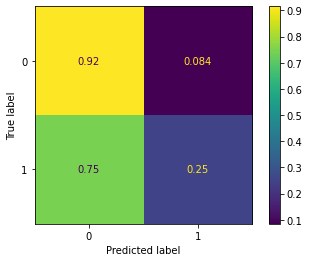

In [140]:
plot_confusion_matrix(xgb_clf_male_KPI_over, male_KPI_X_test, male_KPI_y_test, normalize='true')

In [141]:
male_KPI_over_pred = xgb_clf_male_KPI_over.predict(male_KPI_X_test)
print("Accuracy for male KPI oversampled model: %.2f" % (accuracy_score(male_KPI_y_test, male_KPI_over_pred) * 100))

Accuracy for male KPI oversampled model: 80.28


In [142]:
print(classification_report(male_KPI_y_test, male_KPI_over_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      3263
           1       0.38      0.25      0.30       668

    accuracy                           0.80      3931
   macro avg       0.62      0.58      0.59      3931
weighted avg       0.78      0.80      0.79      3931



Again, our model is doing a poor job of predicting those who were promoted.

Next we will make a model for males who did not meet 80% of their KPIs.

In [143]:
xgb_clf_male_noKPI_over = XGBClassifier(learning_rate=0.1, max_depth=50, n_estimators=100)

In [144]:
xgb_clf_male_noKPI_over.fit(male_noKPI_X_train_over, male_noKPI_y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

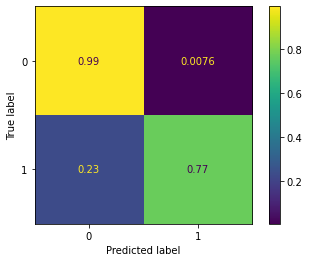

In [145]:
plot_confusion_matrix(xgb_clf_male_noKPI_over, male_noKPI_X_test, male_noKPI_y_test, normalize='true')

In [146]:
male_noKPI_over_pred = xgb_clf_male_noKPI_over.predict(male_noKPI_X_test)
print("Accuracy for male noKPI oversampled model: %.2f" % (accuracy_score(male_noKPI_y_test, male_noKPI_over_pred) * 100))

Accuracy for male noKPI oversampled model: 98.37


In [147]:
print(classification_report(male_noKPI_y_test, male_noKPI_over_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7326
           1       0.80      0.77      0.78       293

    accuracy                           0.98      7619
   macro avg       0.90      0.88      0.89      7619
weighted avg       0.98      0.98      0.98      7619



Finally, an improvement!

# Female (Undersampled)

In [148]:
xgb_clf_female_under = XGBClassifier(learning_rate=0.1, max_depth=50, n_estimators=100)

In [149]:
xgb_clf_female_under.fit(female_X_train_under, female_y_train_under)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

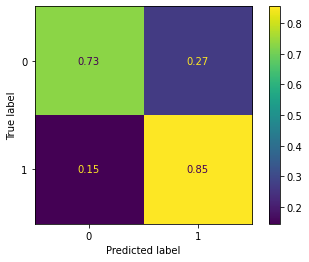

In [150]:
plot_confusion_matrix(xgb_clf_female_under, female_X_test, female_y_test, normalize='true')

In [151]:
female_under_pred = xgb_clf_female_under.predict(female_X_test)
print("Accuracy for female undersampled model: %.2f" % (accuracy_score(female_y_test, female_under_pred) * 100))

Accuracy for female undersampled model: 74.23


In [152]:
print(classification_report(female_y_test, female_under_pred))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84      4454
           1       0.24      0.85      0.37       440

    accuracy                           0.74      4894
   macro avg       0.61      0.79      0.61      4894
weighted avg       0.91      0.74      0.80      4894



Same problems as seen before.

In [153]:
featuredf = pd.DataFrame(xgb_clf_female_under.feature_importances_, female_X_train_under.columns)

In [154]:
featuredf = featuredf.sort_values(by=0, ascending=False)
featuredf[0] = featuredf[0]*100
featuredf = featuredf[:10]

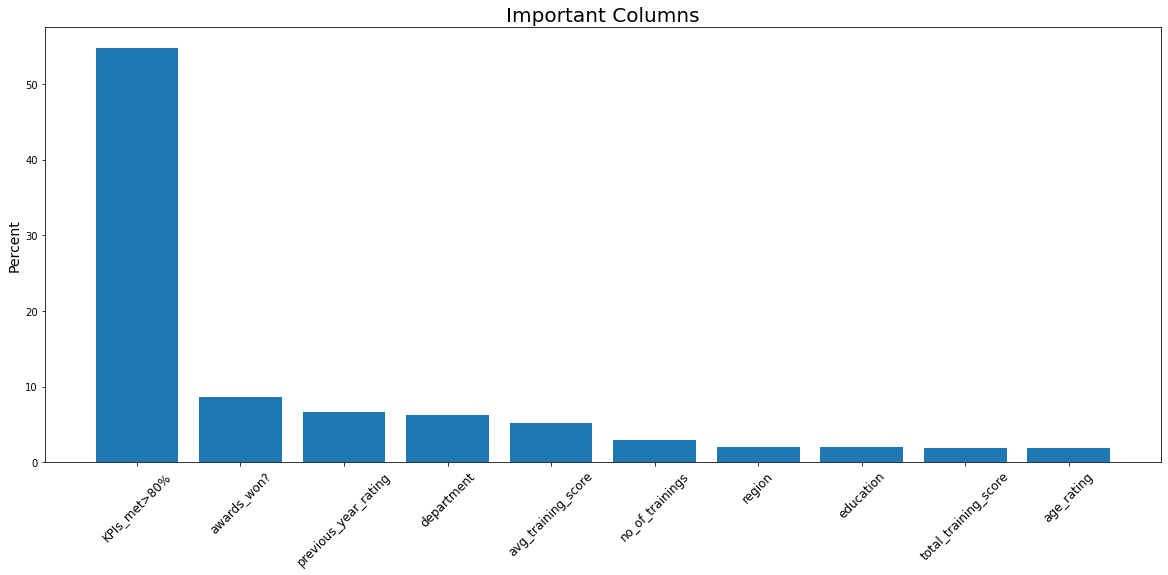

In [155]:
plt.figure(figsize=(20, 8))

x = featuredf.index
y = featuredf[0]

plt.title('Important Columns', fontsize =20)
plt.bar(x, y)
plt.xticks(rotation=45, fontsize = 12)
plt.ylabel('Percent', fontsize=14);

# Female (Oversampled)

In [156]:
xgb_clf_female_over = XGBClassifier(learning_rate=0.1, max_depth=50, n_estimators=100)

In [157]:
xgb_clf_female_over.fit(female_X_train_over, female_y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

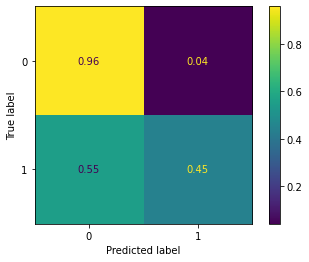

In [158]:
plot_confusion_matrix(xgb_clf_female_over, female_X_test, female_y_test, normalize='true')

In [159]:
female_over_pred = xgb_clf_female_over.predict(female_X_test)
print("Accuracy for female oversampled model: %.2f" % (accuracy_score(female_y_test, female_over_pred) * 100))

Accuracy for female oversampled model: 91.36


In [160]:
female_pred_df = pd.DataFrame(female_over_pred, columns=['predictions'])

In [161]:
female_pred_df.head()

,predictions
0,0
1,0
2,0
3,0
4,0


In [162]:
female_pred_df.to_csv(drive_dir + 'data/female_pred_xgb.csv')

In [163]:
print(classification_report(female_y_test, female_over_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      4454
           1       0.52      0.45      0.48       440

    accuracy                           0.91      4894
   macro avg       0.73      0.70      0.72      4894
weighted avg       0.91      0.91      0.91      4894



In [164]:
featuredf = pd.DataFrame(xgb_clf_female_over.feature_importances_, female_X_train_over.columns)

In [165]:
featuredf = featuredf.sort_values(by=0, ascending=False)
featuredf[0] = featuredf[0]*100
featuredf = featuredf[:10]

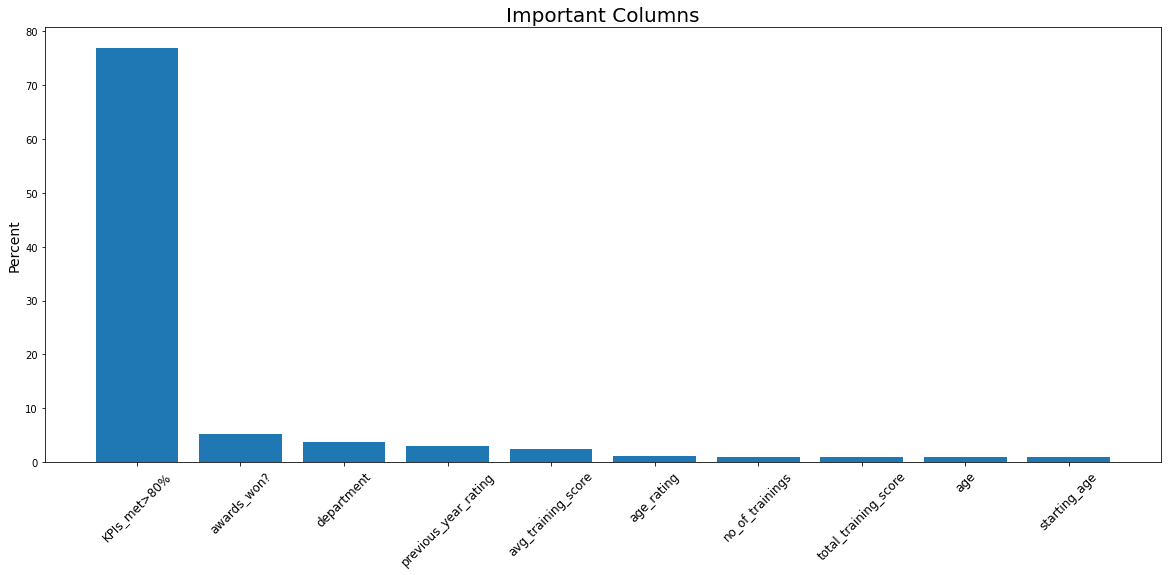

In [166]:
plt.figure(figsize=(20, 8))

x = featuredf.index
y = featuredf[0]

plt.title('Important Columns', fontsize =20)
plt.bar(x, y)
plt.xticks(rotation=45, fontsize = 12)
plt.ylabel('Percent', fontsize=14);

Next we will redo the same thing we did for the male oversampled data. We will split it up by KPIs and create two more models based on those subsets.

In [167]:
female_KPI_df = female_df[female_df['KPIs_met>80%']==1]

In [168]:
female_noKPI_df = female_df[female_df['KPIs_met>80%']==0]

In [169]:
female_KPI_train_df, female_KPI_test_df = train_test_split(female_KPI_df, test_size=0.3, random_state=0, stratify=female_KPI_df['is_promoted'])
female_noKPI_train_df, female_noKPI_test_df = train_test_split(female_noKPI_df, test_size=0.3, random_state=0, stratify=female_noKPI_df['is_promoted'])

In [170]:
feat_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 
             'previous_year_rating', 'length_of_service', 'awards_won?', 'avg_training_score', 
             'starting_age', 'total_training_score', 'previous_year_rating_norm', 'age_rating']
target_col = 'is_promoted'

female_KPI_X_train = female_KPI_train_df[feat_cols]
female_KPI_y_train = female_KPI_train_df[target_col]

female_noKPI_X_train = female_noKPI_train_df[feat_cols]
female_noKPI_y_train = female_noKPI_train_df[target_col]

female_KPI_X_test = female_KPI_test_df[feat_cols]
female_KPI_y_test = female_KPI_test_df[target_col]

female_noKPI_X_test = female_noKPI_test_df[feat_cols]
female_noKPI_y_test = female_noKPI_test_df[target_col]

In [171]:
female_KPI_train_df['is_promoted'].value_counts()

0    3607
1     725
Name: is_promoted, dtype: int64

In [172]:
female_noKPI_train_df['is_promoted'].value_counts()

0    6784
1     302
Name: is_promoted, dtype: int64

In [177]:
female_KPI_train_yes_df = female_KPI_train_df[female_KPI_train_df['is_promoted'] == 1]
female_KPI_train_yes_df = female_KPI_train_yes_df.sample(3607, replace=True)

female_KPI_train_no_df = female_KPI_train_df[female_KPI_train_df['is_promoted'] == 0]

# And now stick both DataFrames together to make a new oversampled training set
female_KPI_train_over_df = pd.concat([female_KPI_train_no_df, female_KPI_train_yes_df])

In [178]:
female_noKPI_train_yes_df = female_noKPI_train_df[female_noKPI_train_df['is_promoted'] == 1]
female_noKPI_train_yes_df = female_noKPI_train_yes_df.sample(6784, replace=True)

female_noKPI_train_no_df = female_noKPI_train_df[female_noKPI_train_df['is_promoted'] == 0]

# And now stick both DataFrames together to make a new oversampled training set
female_noKPI_train_over_df = pd.concat([female_noKPI_train_no_df, female_noKPI_train_yes_df])

In [180]:
female_KPI_train_over_df['is_promoted'].value_counts()

1    3607
0    3607
Name: is_promoted, dtype: int64

In [181]:
female_noKPI_train_over_df['is_promoted'].value_counts()

1    6784
0    6784
Name: is_promoted, dtype: int64

In [182]:
feat_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 
             'previous_year_rating', 'length_of_service', 'awards_won?', 'avg_training_score', 
             'starting_age', 'total_training_score', 'previous_year_rating_norm', 'age_rating']
target_col = 'is_promoted'

female_KPI_X_train_over = female_KPI_train_over_df[feat_cols]
female_KPI_y_train_over = female_KPI_train_over_df[target_col]

In [183]:
female_noKPI_X_train_over = female_noKPI_train_over_df[feat_cols]
female_noKPI_y_train_over = female_noKPI_train_over_df[target_col]

In [ ]:
xgb_clf = XGBClassifier(tree_method='gpu_hist')
hyperparams = {'n_estimators': [100, 150, 200],
               'max_depth': [50, 100, 150, 200, 250],
               'learning_rate': [1e-4, 1e-3, 1e-2, 0.1, 1]}

grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=hyperparams)

grid_search.fit(female_KPI_X_train_over, female_KPI_y_train_over)

In [ ]:
grid_search.best_params_

In [185]:
xgb_clf_female_KPI_over = XGBClassifier(learning_rate=0.1, max_depth=50, n_estimators=100)

In [186]:
xgb_clf_female_KPI_over.fit(female_KPI_X_train_over, female_KPI_y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

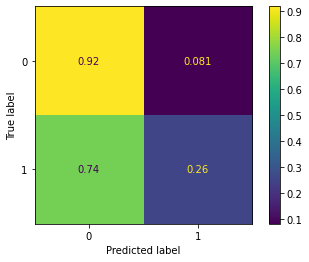

In [187]:
plot_confusion_matrix(xgb_clf_female_KPI_over, female_KPI_X_test, female_KPI_y_test, normalize='true')

In [189]:
female_KPI_over_pred = xgb_clf_female_KPI_over.predict(female_KPI_X_test)
print("Accuracy for female KPI oversampled model: %.2f" % (accuracy_score(female_KPI_y_test, female_KPI_over_pred) * 100))

Accuracy for female KPI oversampled model: 80.83


In [190]:
print(classification_report(female_KPI_y_test, female_KPI_over_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1546
           1       0.39      0.26      0.31       311

    accuracy                           0.81      1857
   macro avg       0.63      0.59      0.60      1857
weighted avg       0.78      0.81      0.79      1857



Same problem!

In [191]:
xgb_clf_female_noKPI_over = XGBClassifier(learning_rate=0.1, max_depth=50, n_estimators=100)

In [192]:
xgb_clf_female_noKPI_over.fit(female_noKPI_X_train_over, female_noKPI_y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=50,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

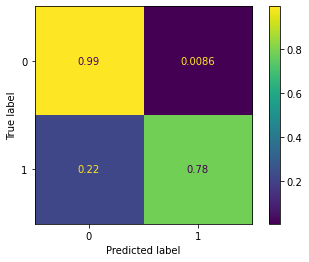

In [193]:
plot_confusion_matrix(xgb_clf_female_noKPI_over, female_noKPI_X_test, female_noKPI_y_test, normalize='true')

In [195]:
female_noKPI_over_pred = xgb_clf_female_noKPI_over.predict(female_noKPI_X_test)
print("Accuracy for male noKPI oversampled model: %.2f" % (accuracy_score(female_noKPI_y_test, female_noKPI_over_pred) * 100))

Accuracy for male noKPI oversampled model: 98.25


In [196]:
print(classification_report(female_noKPI_y_test, female_noKPI_over_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2908
           1       0.80      0.78      0.79       129

    accuracy                           0.98      3037
   macro avg       0.90      0.89      0.89      3037
weighted avg       0.98      0.98      0.98      3037



An improvement just like we saw with males.

# Investigating XGBoost Predictions

In this section we want to investigate our XGBoost model further.

In [198]:
female_X_test['preds'] = female_over_pred

In [199]:
female_X_test.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,starting_age,total_training_score,previous_year_rating_norm,age_rating,age_KPI,preds
26777,4,11,2,0,0,2,37,4.0,2,1,0,59,35,118,0.8,9,4,0
15134,2,14,0,0,1,1,29,4.0,7,1,0,52,22,52,0.8,9,4,0
40991,8,16,2,0,0,1,30,0.0,1,0,0,78,29,78,0.0,10,2,0
44895,4,10,0,0,2,1,39,5.0,7,1,0,60,32,60,1.0,12,4,0
16968,5,18,0,0,0,1,35,5.0,2,1,0,68,33,68,1.0,12,4,0


In [200]:
female_test = pd.merge(female_X_test, female_y_test, left_index=True, right_index=True)

In [201]:
female_correct_test = female_test[female_test['is_promoted'] == female_test['preds']]

In [202]:
female_incorrect_test = female_test[female_test['is_promoted'] != female_test['preds']]

In [203]:
female_incorrect_test.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,starting_age,total_training_score,previous_year_rating_norm,age_rating,age_KPI,preds,is_promoted
48577,8,31,0,0,0,1,34,3.0,5,1,0,79,29,79,0.6,7,4,1,0
39178,7,17,2,0,0,1,37,5.0,8,1,0,50,29,50,1.0,12,4,0,1
40970,5,11,2,0,2,1,39,5.0,7,1,0,74,32,74,1.0,12,4,0,1
14618,2,11,0,0,1,1,37,3.0,2,1,0,52,35,52,0.6,7,4,1,0
15254,5,31,0,0,0,1,34,4.0,6,1,1,69,28,69,0.8,9,4,0,1


In [204]:
female_correct_test.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,starting_age,total_training_score,previous_year_rating_norm,age_rating,age_KPI,preds,is_promoted
26777,4,11,2,0,0,2,37,4.0,2,1,0,59,35,118,0.8,9,4,0,0
15134,2,14,0,0,1,1,29,4.0,7,1,0,52,22,52,0.8,9,4,0,0
40991,8,16,2,0,0,1,30,0.0,1,0,0,78,29,78,0.0,10,2,0,0
44895,4,10,0,0,2,1,39,5.0,7,1,0,60,32,60,1.0,12,4,0,0
16968,5,18,0,0,0,1,35,5.0,2,1,0,68,33,68,1.0,12,4,0,0


In [205]:
female_incorrect_test.shape

(423, 19)

In [206]:
female_correct_test.shape

(4471, 19)

We want to make histograms for when our model predicted incorrectly vs. when our model predicted correctly.

In [209]:
def make_hist(column):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
  ax1 = female_incorrect_test[column].plot(kind='hist', ax=axes[0])
  ax2 = female_correct_test[column].plot(kind='hist', ax =axes[1])
  ax1.set_title('Incorrect Female')
  ax2.set_title('Correct Female')

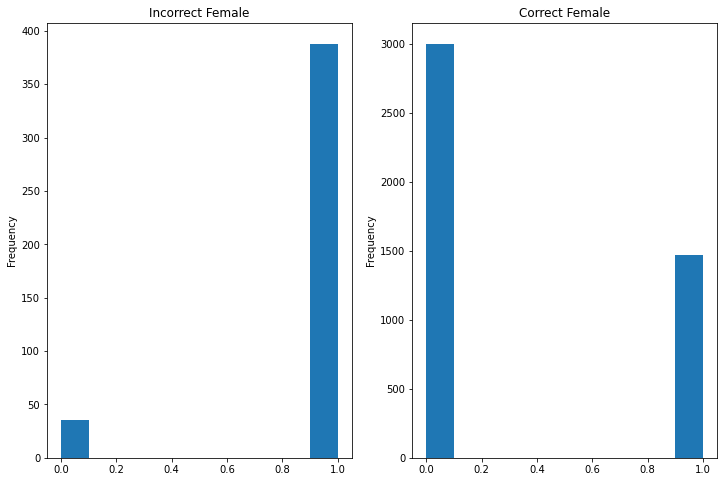

In [210]:
make_hist(column='KPIs_met>80%')

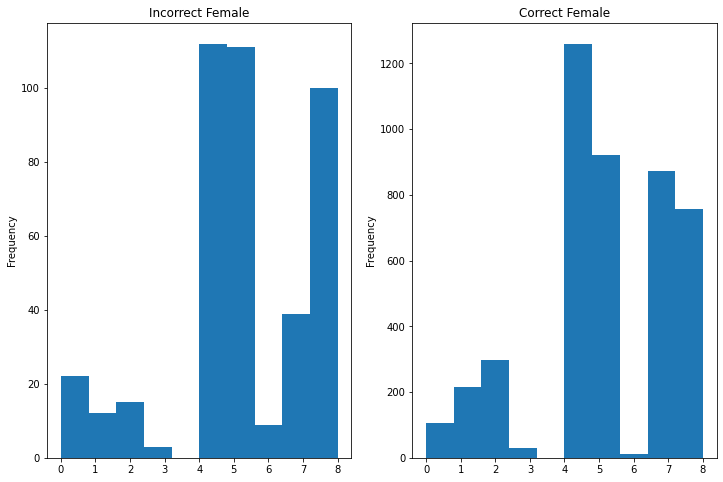

In [211]:
make_hist(column='department')

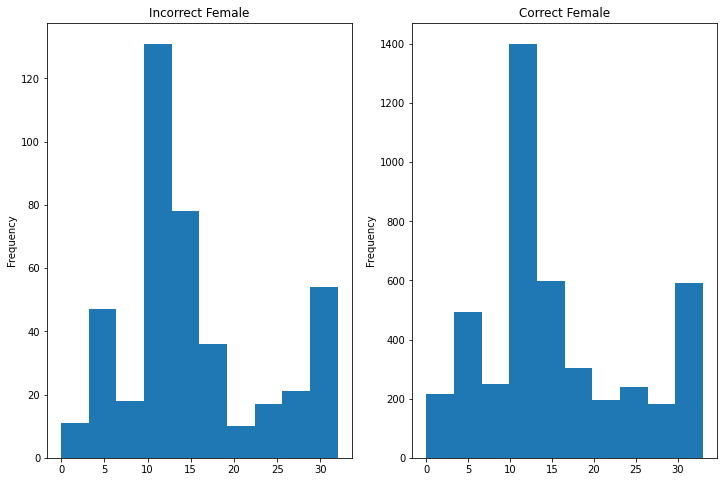

In [212]:
make_hist(column='region')

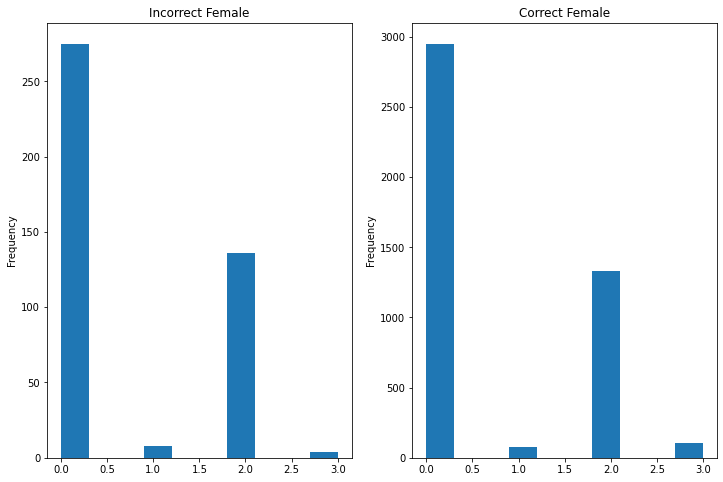

In [213]:
make_hist(column='education')

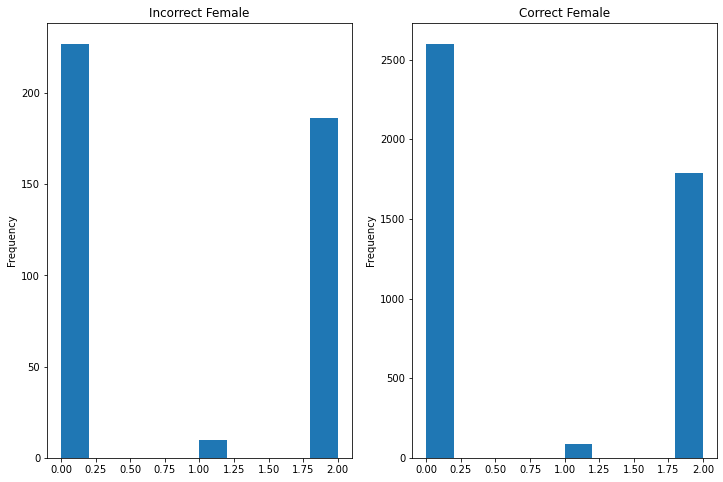

In [214]:
make_hist(column='recruitment_channel')

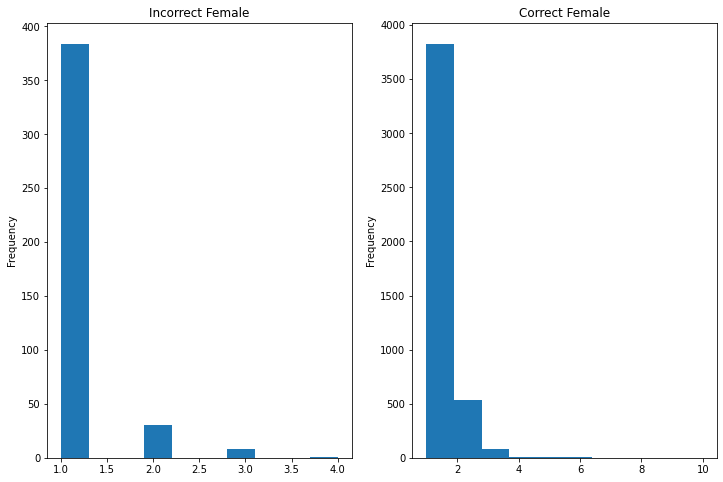

In [215]:
make_hist(column='no_of_trainings')

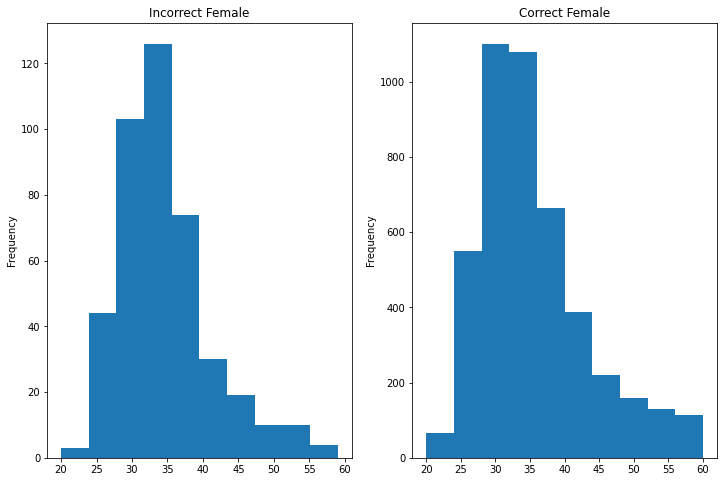

In [216]:
make_hist(column='age')

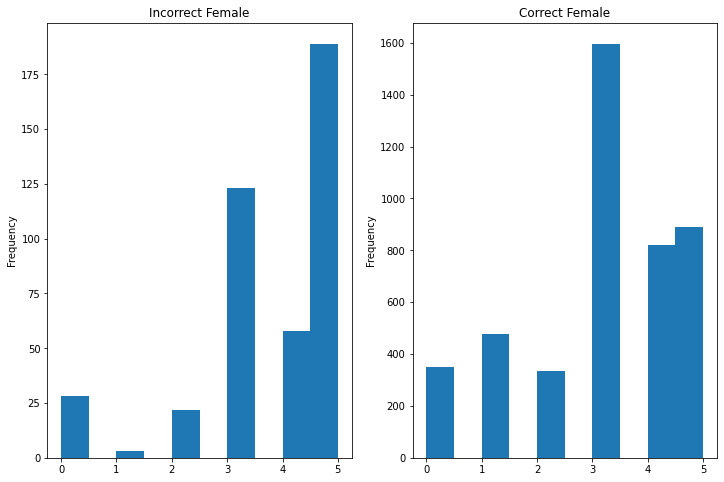

In [217]:
make_hist(column='previous_year_rating')

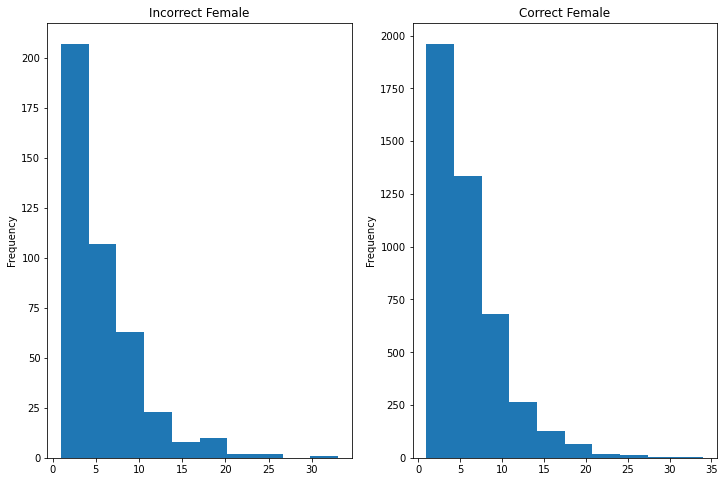

In [218]:
make_hist(column='length_of_service')

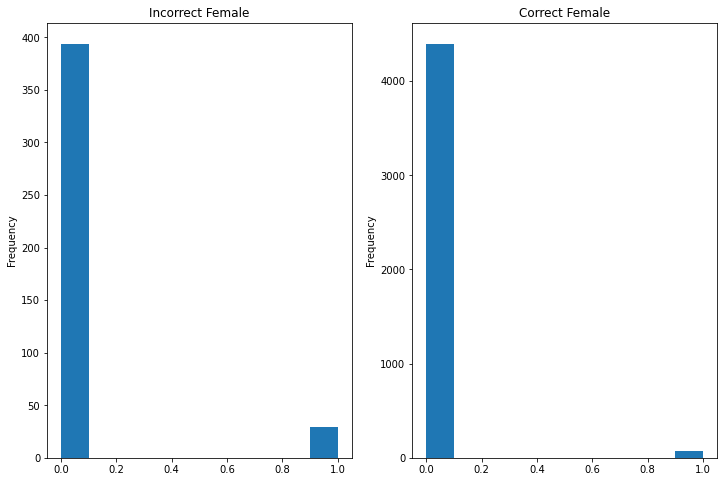

In [219]:
make_hist(column='awards_won?')

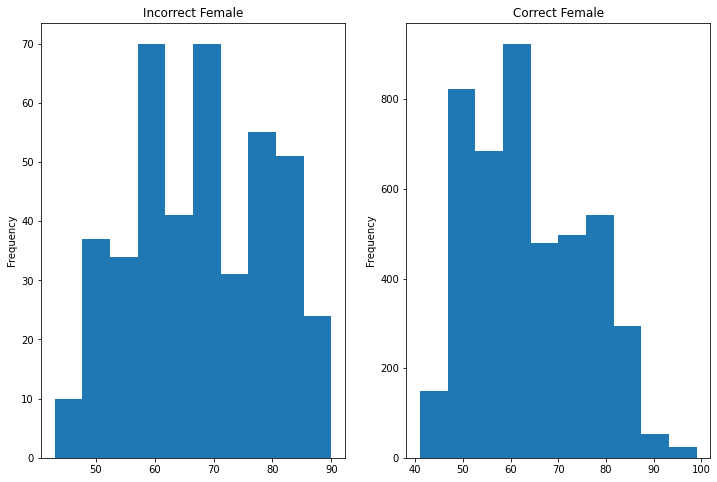

In [220]:
make_hist(column='avg_training_score')

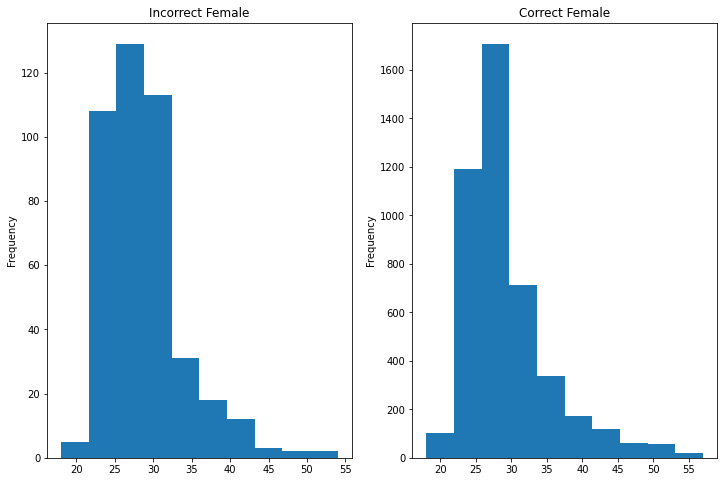

In [222]:
make_hist(column='starting_age')

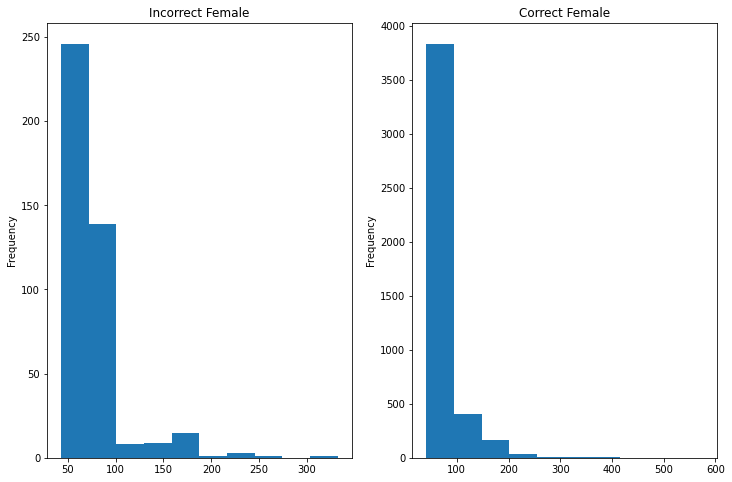

In [223]:
make_hist(column='total_training_score')

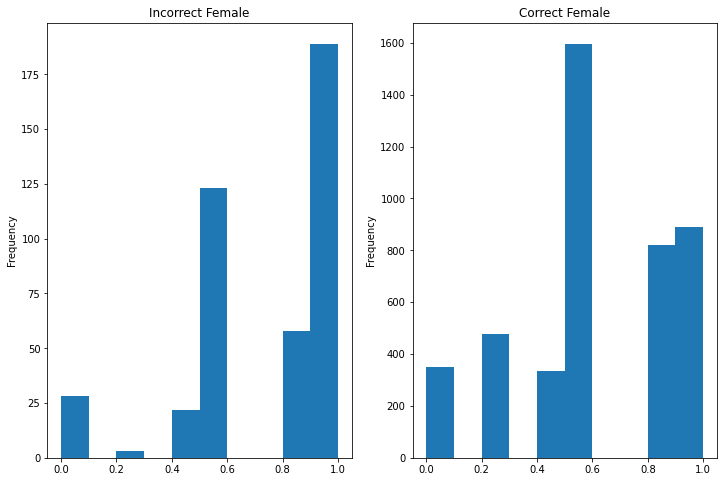

In [224]:
make_hist(column='previous_year_rating_norm')

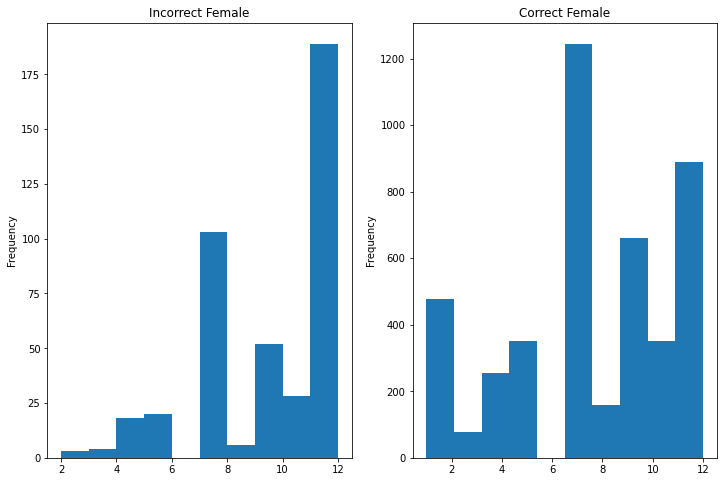

In [225]:
make_hist(column='age_rating')

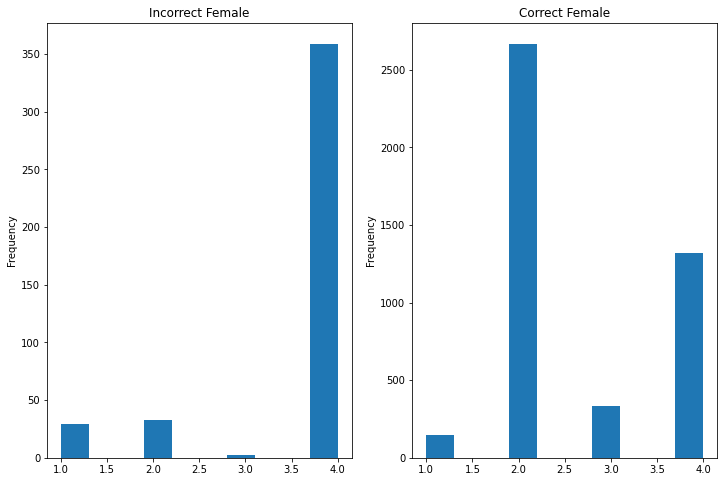

In [226]:
make_hist(column='age_KPI')

Next we will do the same thing for males.

In [229]:
male_X_test['preds'] = male_over_pred

In [230]:
male_X_test.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,starting_age,total_training_score,previous_year_rating_norm,age_rating,age_KPI,preds
49286,0,31,2,1,2,1,34,4.0,9,0,0,87,25,87,0.8,9,2,0
5153,7,24,0,1,0,1,40,2.0,11,0,0,49,29,49,0.4,4,2,0
25050,4,11,0,1,2,1,30,5.0,2,1,0,59,28,59,1.0,12,4,0
46561,7,25,0,1,2,1,42,4.0,14,0,0,46,28,46,0.8,8,2,0
17616,4,11,0,1,1,2,35,5.0,7,0,0,61,28,122,1.0,12,2,0


In [231]:
male_test = pd.merge(male_X_test, male_y_test, left_index=True, right_index=True)

In [232]:
male_correct_test = male_test[male_test['is_promoted'] == male_test['preds']]

In [233]:
male_incorrect_test = male_test[male_test['is_promoted'] != male_test['preds']]

In [234]:
male_incorrect_test.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,starting_age,total_training_score,previous_year_rating_norm,age_rating,age_KPI,preds,is_promoted
25050,4,11,0,1,2,1,30,5.0,2,1,0,59,28,59,1.0,12,4,0,1
17536,4,6,0,1,0,1,38,5.0,5,1,0,61,33,61,1.0,12,4,0,1
5065,7,15,2,1,0,2,39,3.0,2,1,0,47,37,94,0.6,7,4,0,1
18290,7,11,0,1,1,2,28,5.0,6,1,0,48,22,96,1.0,12,4,0,1
32136,4,6,0,1,0,1,34,5.0,2,0,0,67,32,67,1.0,12,2,1,0


In [235]:
male_correct_test.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,starting_age,total_training_score,previous_year_rating_norm,age_rating,age_KPI,preds,is_promoted
49286,0,31,2,1,2,1,34,4.0,9,0,0,87,25,87,0.8,9,2,0,0
5153,7,24,0,1,0,1,40,2.0,11,0,0,49,29,49,0.4,4,2,0,0
46561,7,25,0,1,2,1,42,4.0,14,0,0,46,28,46,0.8,8,2,0,0
17616,4,11,0,1,1,2,35,5.0,7,0,0,61,28,122,1.0,12,2,0,0
28738,4,28,2,1,0,1,49,3.0,18,0,0,57,31,57,0.6,5,3,0,0


In [236]:
male_incorrect_test.shape

(968, 19)

In [237]:
male_correct_test.shape

(10581, 19)

In [238]:
def make_hist(column):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
  ax1 = male_incorrect_test[column].plot(kind='hist', ax=axes[0])
  ax2 = male_correct_test[column].plot(kind='hist', ax =axes[1])
  ax1.set_title('Incorrect Male')
  ax2.set_title('Correct Male')

In [239]:
male_incorrect_test.columns

Index(['department', 'region', 'education', 'gender', 'recruitment_channel',
       'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'KPIs_met>80%', 'awards_won?', 'avg_training_score', 'starting_age',
       'total_training_score', 'previous_year_rating_norm', 'age_rating',
       'age_KPI', 'preds', 'is_promoted'],
      dtype='object')

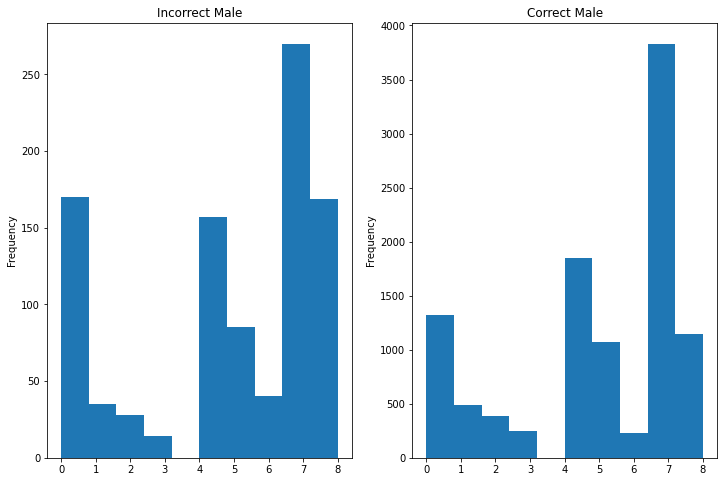

In [240]:
make_hist(column='department')

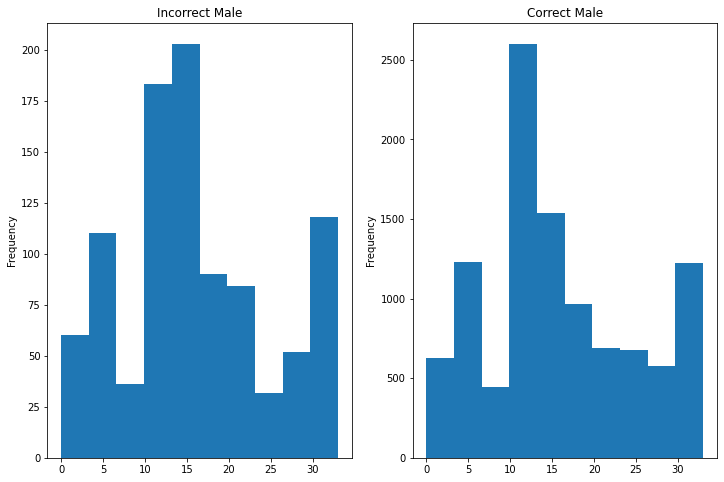

In [241]:
make_hist(column='region')

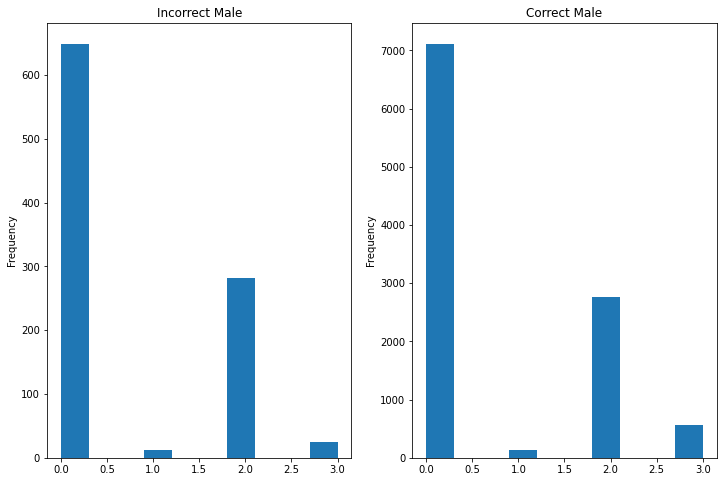

In [242]:
make_hist(column='education')

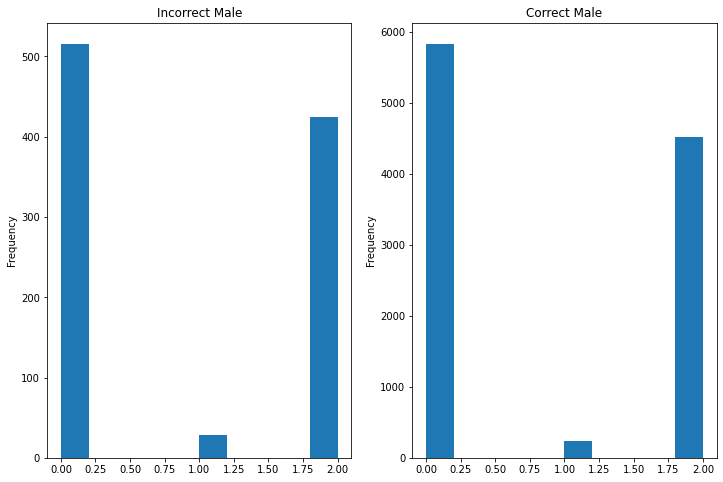

In [243]:
make_hist(column='recruitment_channel')

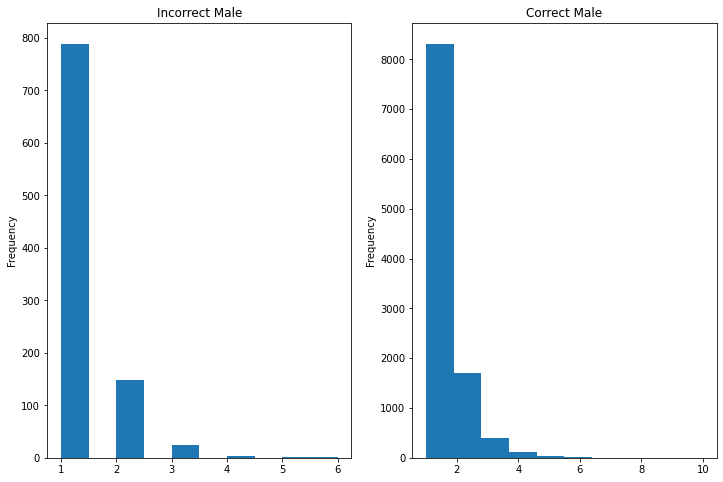

In [244]:
make_hist(column='no_of_trainings')

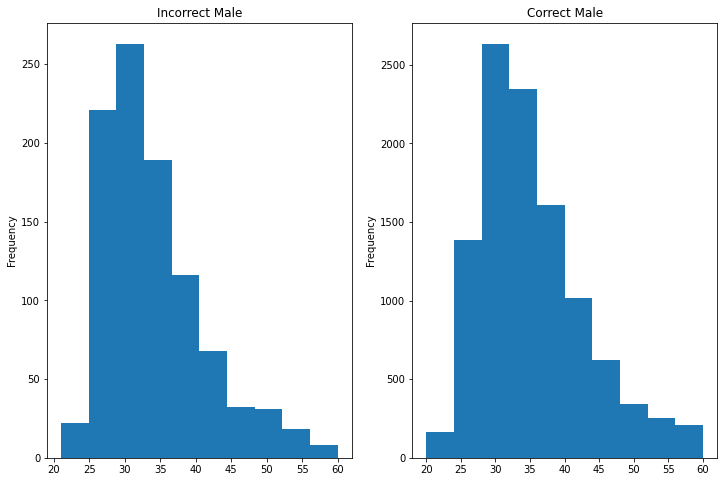

In [245]:
make_hist(column='age')

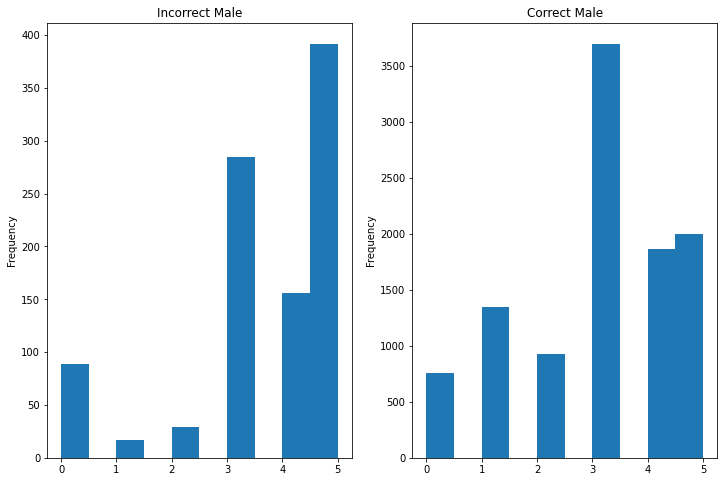

In [246]:
make_hist(column='previous_year_rating')

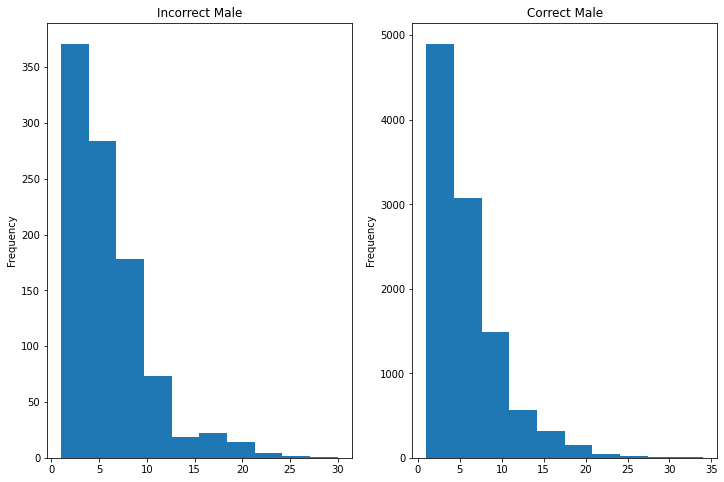

In [247]:
make_hist(column='length_of_service')

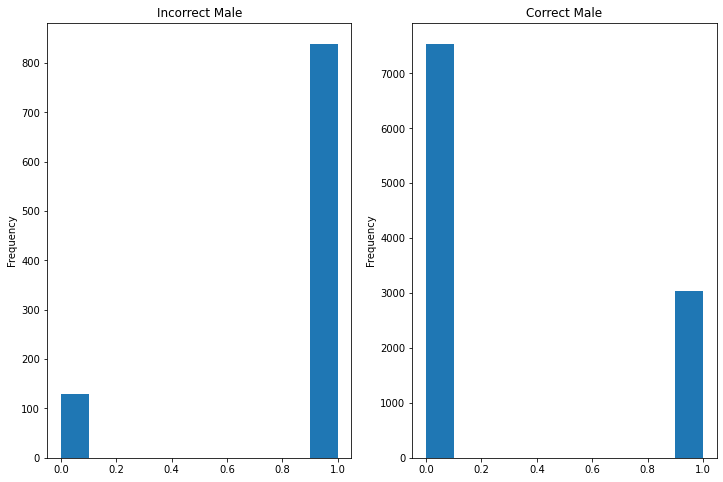

In [248]:
make_hist(column='KPIs_met>80%')

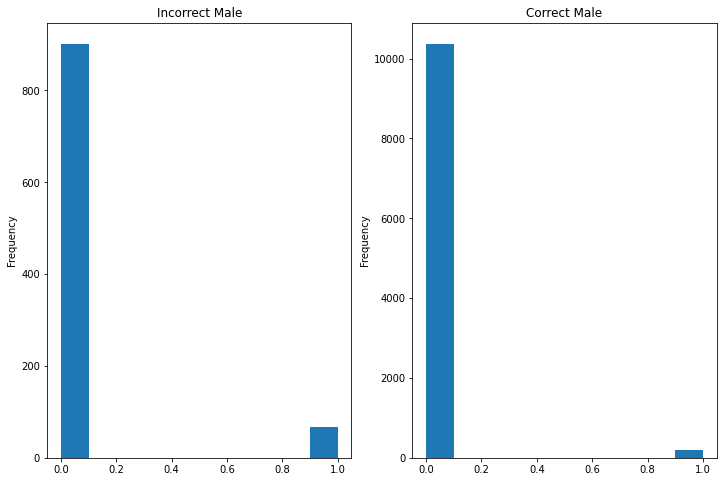

In [249]:
make_hist(column='awards_won?')

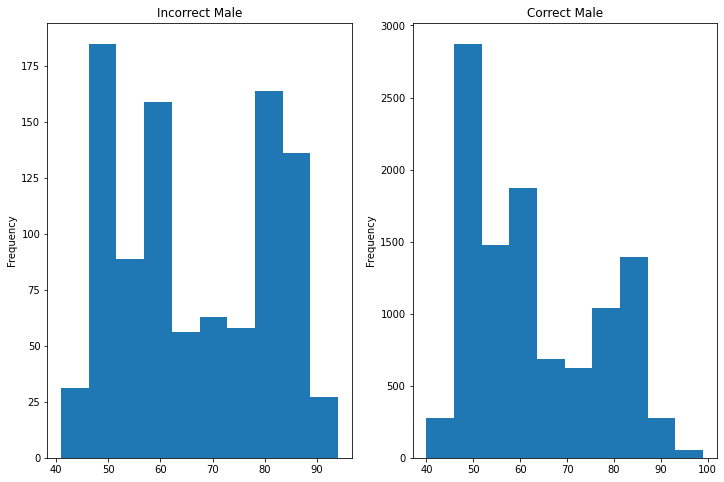

In [250]:
make_hist(column='avg_training_score')

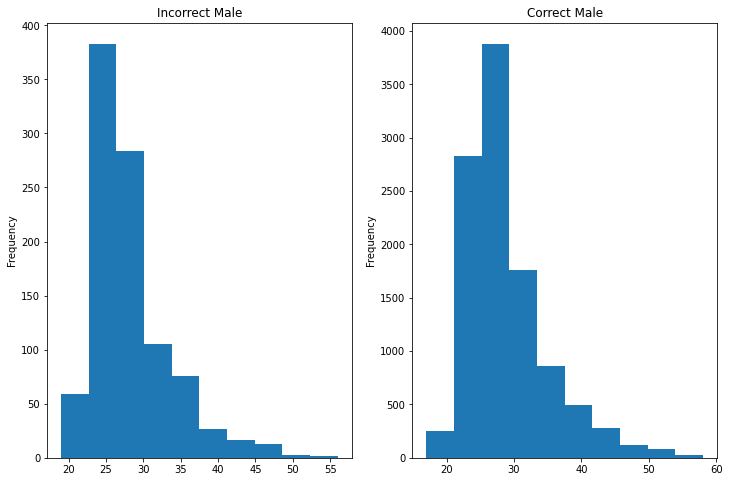

In [251]:
make_hist(column='starting_age')

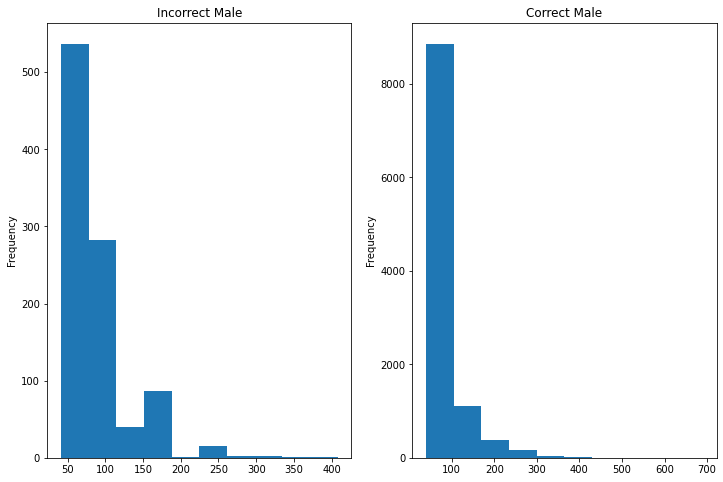

In [252]:
make_hist(column='total_training_score')

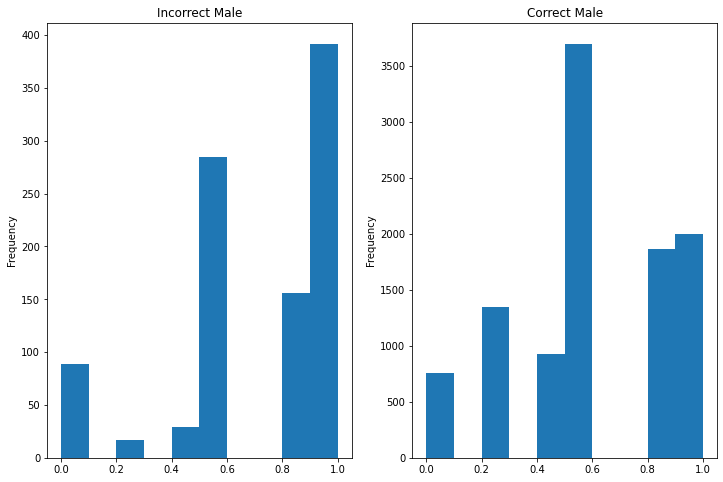

In [253]:
make_hist(column='previous_year_rating_norm')

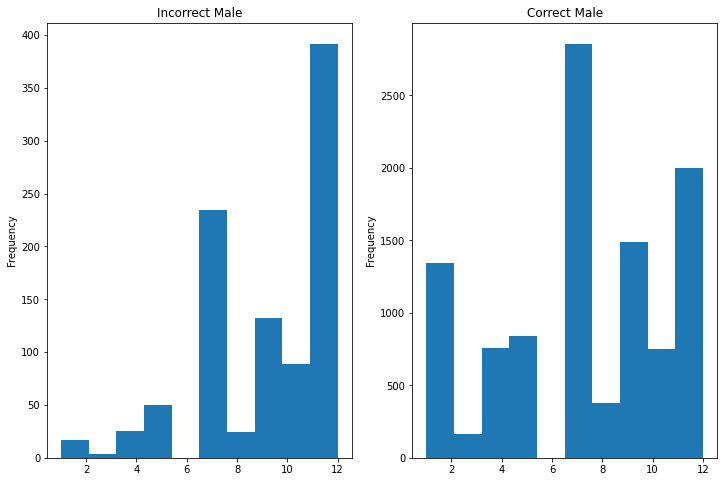

In [254]:
make_hist(column='age_rating')

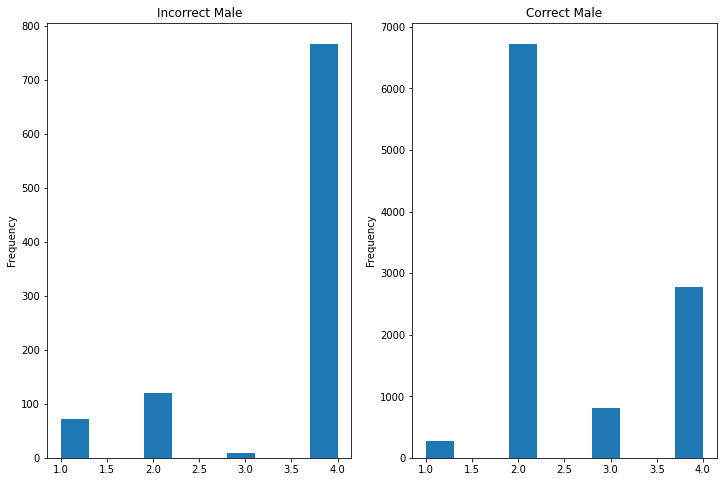

In [255]:
make_hist(column='age_KPI')